***Model Evaluation***

**Dataset**<br>
In this homework we will use credit card data from the book "Econometric Analysis" available from [Kaggle](https://www.kaggle.com/datasets/dansbecker/aer-credit-card-data).<br>
<br>
Goal: to inspect the output of different evaluation metrics by creating a classification model (target column card).

In [1]:
# Preparing the environment
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import (
    pyplot as plt,
)  # library for creating static, animated, and interactive visualizations
import seaborn as sns  # data visualization library based on matplotlib

Exploratory Data Analysis // **EDA**

In [2]:
# Load the Dataset into a DataFrame
ds = pd.read_csv("AER_credit_card_data.csv")
df = ds.copy()
df.head(2)

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.52,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.42,0.005217,9.854167,no,no,3,34,1,13


In [3]:
df.columns = df.columns.str.lower().str.replace(" ", "_")

string_columns = list(df.dtypes[df.dtypes == "object"].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(" ", "_")
    
df['card'] = (df['card'] == 'yes').astype(int)
df.head(2) 

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,1,0,37.66667,4.52,0.033270,124.983300,yes,no,3,54,1,12
1,1,0,33.25000,2.42,0.005217,9.854167,no,no,3,34,1,13


In [4]:
print(f"\ndataset describe:")
display(df.describe())
print(f"\ndatasetColumns:")
display(df.columns)
print(f"\ndataset len:")
display(len(df))
print(f"\ndataset types :")
df.dtypes


dataset describe:


,card,reports,age,income,share,expenditure,dependents,months,majorcards,active
count,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000
mean,0.775588,0.456406,33.213103,3.365376,0.068732,185.057071,0.993935,55.267627,0.817286,6.996967
std,0.417353,1.345267,10.142783,1.693902,0.094656,272.218917,1.247745,66.271746,0.386579,6.305812
min,0.000000,0.000000,0.166667,0.210000,0.000109,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,25.416670,2.243750,0.002316,4.583333,0.000000,12.000000,1.000000,2.000000
50%,1.000000,0.000000,31.250000,2.900000,0.038827,101.298300,1.000000,30.000000,1.000000,6.000000
75%,1.000000,0.000000,39.416670,4.000000,0.093617,249.035800,2.000000,72.000000,1.000000,11.000000
max,1.000000,14.000000,83.500000,13.500000,0.906320,3099.505000,6.000000,540.000000,1.000000,46.000000



datasetColumns:


Index(['card', 'reports', 'age', 'income', 'share', 'expenditure', 'owner',
       'selfemp', 'dependents', 'months', 'majorcards', 'active'],
      dtype='object')


dataset len:


1319


dataset types :


card             int32
reports          int64
age            float64
income         float64
share          float64
expenditure    float64
owner           object
selfemp         object
dependents       int64
months           int64
majorcards       int64
active           int64
dtype: object

**Preparation**<br>
I will create a target variable, mapping yes to 1 and no to 0.<br>
I will split the dataset into 3 parts: training/validation/test with a 60%/20%/20% distribution. <br>
I will use the function train_test_split with random_state=1 for this.<br>

In [5]:
numerical = ['age', 'reports', 'income', 'share', 'expenditure', 'dependents', 'months', 'majorcards', 'active']
categorical = ['owner', 'selfemp']

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
# splitting the data:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

n = len(df)
n_train_full = len(df_train_full)
n_train = len(df_train)
n_val = len(df_val)
n_test = len(df_test)

print(f"n_dataset = \t\t{n}")
print(f"n_full_train = \t\t{n_train_full}")
print(f"n_train = \t\t{n_train}")
print(f"n_val = \t\t{n_val}")
print(f"n_test = \t\t{n_test}")
print(f"check of sum:\n(train + val + test) = \t{n_train + n_val + n_test}")

n_dataset = 		1319
n_full_train = 		1055
n_train = 		791
n_val = 		264
n_test = 		264
check of sum:
(train + val + test) = 	1319


**Question 1**<br>

I will use the ROC AUC to evaluate the importance of features for numeric variables.<br>
For each numeric variable, I will use it as an outcome and calculate the AUC with the card variable.<br>
I will use the training dataset for this.<br><br>

If the AUC is < 0.5, I will invert the variable by putting a '-' in front of it<br>
(e.g. -df_train['expenditure']).<br>

If the AUC is below 0.5, if the variable is negatively correlated with the target variable. <br>
I will change the direction of the correlation by negating that variable - then the negative correlation becomes positive. <br><br>

Goal: Which numerical variable (of the following 4) has the highest AUC?<br>

reports<br>
dependents<br>
active<br>
share<br>



In [8]:
from sklearn.metrics import auc

In [9]:
def scores_by_feature(feature):
    scores = []

    thresholds = np.linspace(df_train[feature].min(), df_train[feature].max(), 50)

    for t in thresholds:
        actual_positive = df_train["card"] == 1
        actual_negative = df_train["card"] == 0
        predict_positive = df_train[feature] >= t
        predict_negative = df_train[feature] < t
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
        scores.append((t, tp, fp, fn, tn))

    columns = ["t", "tp", "fp", "fn", "tn"]
    df_scores = pd.DataFrame(scores, columns=columns)
    df_scores["tpr"] = df_scores["tp"] / (df_scores["tp"] + df_scores["fn"])
    df_scores["fpr"] = df_scores["fp"] / (df_scores["fp"] + df_scores["tn"])
    return df_scores

In [10]:
df_scores_reports = scores_by_feature("reports")
df_scores_dependents = scores_by_feature("dependents")
df_scores_active = scores_by_feature("active")
df_scores_share = scores_by_feature("share")

auc_reports = auc(df_scores_reports["fpr"], df_scores_reports["tpr"])
auc_dependents = auc(df_scores_dependents["fpr"], df_scores_dependents["tpr"])
auc_active = auc(df_scores_active["fpr"], df_scores_active["tpr"])
auc_share = auc(df_scores_share["fpr"], df_scores_share["tpr"])

print(f'AUC results for features:')
print(f'\treports = \t{auc_reports}')
print(f'\tdependents = \t{auc_dependents}')
print(f'\tactive = \t{auc_active}')
print(f'\tshare = \t{auc_share}')

AUC results for features:
	reports = 	0.28333701393106236
	dependents = 	0.46719667273965293
	active = 	0.6043173411362006
	share = 	0.9201954397394136


In [11]:
def scores_by_feature_neg(feature):
    scores = []

    thresholds = np.linspace(df_train[feature].min(), df_train[feature].max(), 50)

    for t in thresholds:
        actual_positive = df_train["card"] == 1
        actual_negative = df_train["card"] == 0
        predict_positive = df_train[feature] < t
        predict_negative = df_train[feature] >= t
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
        scores.append((t, tp, fp, fn, tn))
        
    columns = ["t", "tp", "fp", "fn", "tn"]
    df_scores = pd.DataFrame(scores, columns=columns)
    df_scores["tpr"] = df_scores["tp"] / (df_scores["tp"] + df_scores["fn"])
    df_scores["fpr"] = df_scores["fp"] / (df_scores["fp"] + df_scores["tn"])
    return df_scores

In [12]:
df_scores_reports = scores_by_feature_neg('reports')
df_scores_dependents = scores_by_feature_neg('dependents')
df_scores_active = scores_by_feature('active')
df_scores_share = scores_by_feature('share')

auc_reports = auc(df_scores_reports['fpr'], df_scores_reports['tpr'])
auc_dependents = auc(df_scores_dependents['fpr'], df_scores_dependents['tpr'])
auc_active = auc(df_scores_active['fpr'], df_scores_active['tpr'])
auc_share = auc(df_scores_share['fpr'], df_scores_share['tpr'])

print(f'AUC results for features:')
print(f'\treports = \t{auc_reports}')
print(f'\tdependents = \t{auc_dependents}')
print(f'\tactive = \t{auc_active}')
print(f'\tshare = \t{auc_share}')

AUC results for features:
	reports = 	0.7110132685548134
	dependents = 	0.5215038922320985
	active = 	0.6043173411362006
	share = 	0.9201954397394136


**Training the model**<br><br>

From now on, use these columns only:<br>

["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]<br>

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:<br>

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression


In [14]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values
y_train_full = df_train_full.card.values

**Question 2**<br><br>

GOAL: what is the AUC of this model on the validation dataset? <br>Result (round to 3 digits)

In [15]:
def train(df_train, y_train, C):
    dicts = df_train[categorical + numerical].to_dict(orient="records")

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver="liblinear", max_iter=1000, C=C)
    model.fit(X_train, y_train)

    return dv, model

In [16]:
dv, model = train(df_train, y_train, C=1)

In [17]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient="records")

    X = dv.transform(dicts)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [18]:
y_pred = predict(df_val, dv, model)

In [19]:
from sklearn.metrics import roc_auc_score

In [20]:
auc = roc_auc_score(y_val, y_pred)

print(f"\nAnswer to question 2:")
print(f"AUC of this model on the validation dataset is: {round(auc, 3)}")


Answer to question 2:
AUC of this model on the validation dataset is: 0.995


**Question 3**<br><br>

I will calculate the precision and recall for our model.<br>

I will evaluate the model on a validation dataset for all thresholds from 0.0 to 1.0 with a step of 0.01<br>
I will calculate precision and recall for each threshold<br>
For the presentation I will use plot<br>

GOAL: At which threshold do the precision and recall curves intersect?

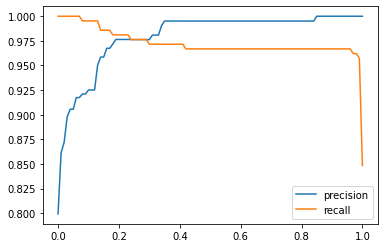

In [21]:
thresholds = np.linspace(0, 1, 101)
scores = []
for t in thresholds:

    positive_predictions = y_pred >= t
    negative_predictions = y_pred < t

    positive_actual = y_val == 1
    negative_actual = y_val == 0

    tp = (positive_predictions & positive_actual).sum()
    fp = (positive_predictions & negative_actual).sum()
    tn = (negative_predictions & negative_actual).sum()
    fn = (negative_predictions & positive_actual).sum()
    score = (t, tp, fp, tn, fn)
    scores.append(score)

columns = ["t", "tp", "fp", "tn", "fn"]
df_scores = pd.DataFrame(scores, columns=columns)
df_scores["p"] = df_scores["tp"] / (df_scores["tp"] + df_scores["fp"])
df_scores["r"] = df_scores["tp"] / (df_scores["tp"] + df_scores["fn"])
# df_scores["fpr"] = df_scores["fp"] / (df_scores["tn"] + df_scores["fp"])
# df_scores["tpr"] = df_scores["tp"] / (df_scores["tp"] + df_scores["fn"])

plt.plot(df_scores["t"], df_scores["p"], label="precision")
plt.plot(df_scores["t"], df_scores["r"], label="recall")
plt.legend()

In [22]:
print(f"\nAnswer to question 3:")
print(f"Precision and recall curves intersect at threshold: 0.3")


Answer to question 3:
Precision and recall curves intersect at threshold: 0.3


**Question 4**

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing $F_1$:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

I will calculate F1 for all thresholds from 0.0 to 1.0 with an increment of 0.01 using the validation set

GOAL: At which threshold F1 is maximal?

t       0.350000
tp    205.000000
fp      1.000000
tn     52.000000
fn      6.000000
p       0.995146
r       0.971564
f1      0.983213
Name: 35, dtype: float64

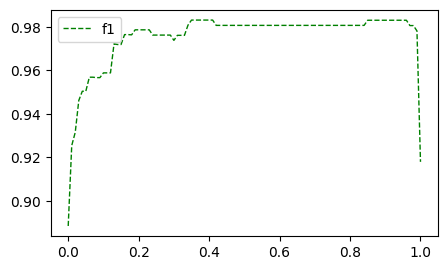

In [23]:
df_scores["f1"] = (
    2
    * df_scores["p"]
    * df_scores["r"]
    / (df_scores["p"] + df_scores["r"])
)

display(df_scores.loc[df_scores.f1.argmax()])

plt.figure(figsize=(5, 3), dpi=100)
plt.plot(
    df_scores["t"],
    df_scores["f1"],
    label="f1",
    color="green",
    linestyle="dashed",
    linewidth=1,
)
plt.legend()

In [24]:
print(f"\nAnswer to question 4:")
print(f"The highest value of the F1 score is for the threshold: 0.35")


Answer to question 4:
The highest value of the F1 score is for the threshold: 0.35


**Question 5**

I will use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:<br>
KFold(n_splits=5, shuffle=True, random_state=1)

Assumptions: <br>
iterate over the different folds of df_full_train<br>
Split the data into training and validation<br>
Train the model on training with these parameters:<br>
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)<br>
Use AUC to evaluate the model in validation.
<br><br>
GOAL: How large is the standard deviation of the AUC results across folds?

In [25]:
from sklearn.model_selection import KFold

In [28]:
n_splits = 5

scores =[]

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_train_full):

    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]

    y_train = df_train.card.values
    y_val = df_val.card.values

    dv, model = train(df_train, y_train, C=1)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    
    scores.append(auc)

print(f"\nAnswer to question 5:")
print(f'The standard deviation of the AUC results in each fold is: {np.round(np.std(scores),3)}')


Answer to question 5:
The standard deviation of the AUC results in each fold is: 0.003


**Question 6** <br>

I will use 5-fold cross-validation to find the best parameter C<br>

Assumptions:<br>
Iterate over the following values of C: [0.01, 0.1, 1, 10]<br>
Initialise KFold with the same parameters as before<br>
Use these parameters for the model:<br> LogisticRegression(solver='liblinear', C=C, max_iter=1000)<br>
Calculate the mean score as well as the std (round the mean and std to 3 decimal digits)<br><br>

GOAL: Which C leads to the best average result?

In [29]:
from tqdm.auto import tqdm

In [35]:
n_splits = 5

for C in tqdm([0.01, 0.1, 1, 10]):

    scores = []

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    for train_idx, val_idx in kfold.split(df_train_full):

        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]
        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print(
        f"C={C}, Mean Scores: {np.round(np.mean(scores),3)}, STD: {np.round(np.std(scores),3)}"
    )

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01, Mean Scores: 0.992, STD: 0.006
C=0.1, Mean Scores: 0.995, STD: 0.004
C=1, Mean Scores: 0.996, STD: 0.003
C=10, Mean Scores: 0.996, STD: 0.003
